# Importing the dependencies and Load the Data

In [2]:
! pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import numpy as np 
import tensorflow as tf
import pandas as pd

In [2]:
df=pd.read_csv('./train.csv')
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
df.shape

(159571, 8)

# Preprocessing the Comments

The first step in preproceesing is Tokenization. By using TextVectorization we can do Tokenization.
Text vectorization is a preprocessing layer which map the text features to integer sequences.

The args of TextVectorization we use here are:
1.max_features which are max number of words in vocab
2.output_sequence_length which is length of output word
3.output_mode which is output of layers


In [4]:
from tensorflow.keras.layers import TextVectorization
# Separating the text and labels as X and y
X=df['comment_text'][:50000]
y=df[df.columns[2:]][:50000].values

# intilization of TextVectorization
max_features=10000
output_length=2000

vectorizer=TextVectorization(max_tokens=max_features,
                            output_sequence_length=output_length,
                            output_mode='int')
print(X),print(y)

0        Explanation\nWhy the edits made under my usern...
1        D'aww! He matches this background colour I'm s...
2        Hey man, I'm really not trying to edit war. It...
3        "\nMore\nI can't make any real suggestions on ...
4        You, sir, are my hero. Any chance you remember...
                               ...                        
49995    "\nWell, she's done writing articles. But does...
49996    There was also an Atlantis wrap back in 2001. ...
49997    "\nI've removed the various ""references"" as ...
49998    RE: Removal of Templates \n\nI would be most g...
49999    Exactly. I want the drawing to have come first...
Name: comment_text, Length: 50000, dtype: object
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 ...
 [0 0 0 0 0 0]
 [1 0 0 0 1 0]
 [0 0 0 0 0 0]]


(None, None)

Now to learn the vocabulary we need to call a method called "adpat" which learns the text in the vocabulary.

In [5]:
vectorizer.adapt(X.values)

Below we have taken an example to see how adapt works.The Text has 5 words, vectorizer converts the words to tokens and keep 0 till the output_length 

In [6]:
vectorizer("This is Toxic Comment Classification")


<tf.Tensor: shape=(2000,), dtype=int64, numpy=array([  14,    9, 9098, ...,    0,    0,    0], dtype=int64)>

In [7]:
vectorized_text=vectorizer(X.values)

Now the vectorized text is a sequence of integers of shape 159571which is len(X) and output_length

In [8]:
vectorized_text

<tf.Tensor: shape=(50000, 2000), dtype=int64, numpy=
array([[ 680,   74,    2, ...,    0,    0,    0],
       [   1,   54, 2324, ...,    0,    0,    0],
       [ 489,  430,   72, ...,    0,    0,    0],
       ...,
       [ 133,  182,    2, ...,    0,    0,    0],
       [ 752, 1038,    4, ...,    0,    0,    0],
       [ 596,    8,  105, ...,    0,    0,    0]], dtype=int64)>

Next is to create a tensorflow data pipeline which is useful particulary when we have got data that don't fit in memory.
Suppose we want to create a dataset from data in memory we can use "tf.data.dataset.from_tensor_slices()".

Then we caches the elements in the dataset.Then we shuffle the elements in the dataset and we take consecutive elements of dataset into batches  and ends with prefetch which will allow later elements to prepare while current elements are processing.

The new dataset after transformation can be seen when we use as_numpy_iterator returns the elements of
dataset to numpy

In [9]:
dataset=tf.data.Dataset.from_tensor_slices((vectorized_text,y))
dataset=dataset.cache()
dataset=dataset.shuffle(1000)
dataset=dataset.batch(16)
dataset=dataset.prefetch(8)




Splitting the dataset into train, test and validation


In [10]:
train=dataset.take(int(len(dataset)*.7))
val=dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test=dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [11]:
len(dataset),len(train),len(val),len(test)

(3125, 2187, 625, 312)

# Creating a Sequential Model

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,LSTM,Bidirectional,Dense,Dropout

In [13]:
model=Sequential()
model.add(Embedding(max_features+1,32))
model.add(Bidirectional(LSTM(32,activation='tanh')))
model.add(Dense(128,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(6,activation='sigmoid'))

In [14]:
model.compile(optimizer='adam',loss='BinaryCrossentropy')

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          320032    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [16]:
history=model.fit(train,epochs=4,validation_data=val)

Epoch 1/4
2187/2187 [==============================] - 5563s 3s/step - loss: 0.0843 - val_loss: 0.0617
Epoch 2/4
2187/2187 [==============================] - 6667s 3s/step - loss: 0.0548 - val_loss: 0.0552
Epoch 3/4
2187/2187 [==============================] - 4462s 2s/step - loss: 0.0490 - val_loss: 0.0561
Epoch 4/4
2187/2187 [==============================] - 3886s 2s/step - loss: 0.0444 - val_loss: 0.0597


In [17]:
from matplotlib import pyplot as plt

<Figure size 576x360 with 0 Axes>

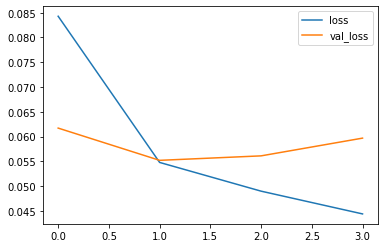

In [18]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# Make Predictions

Now use the model and predict for any sentence. but before passing the text to model tokenize the text

we can also predict for batch of sentences 

In [57]:
# Predicting for any Custom Text
input_text=vectorizer("You are a freak!")
input_text


<tf.Tensor: shape=(2000,), dtype=int64, numpy=array([ 7, 19,  6, ...,  0,  0,  0], dtype=int64)>

In [58]:
res=model.predict(np.array([input_text]))
res

1/1 [==============================] - 0s 81ms/step


array([[0.91361207, 0.02961496, 0.5065496 , 0.03892843, 0.47127154,
        0.10434879]], dtype=float32)

In [32]:
# Predicting for batch of test sentences
batch_X,batch_y=test.as_numpy_iterator().next()
batch_X,batch_y


(array([[ 916,  213, 2318, ...,    0,    0,    0],
        [1480,    7,   20, ...,    0,    0,    0],
        [ 494,   47,  169, ...,    0,    0,    0],
        ...,
        [ 883,  887,  178, ...,    0,    0,    0],
        [4333, 7493,    8, ...,    0,    0,    0],
        [ 816,    8,  693, ...,    0,    0,    0]], dtype=int64),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]], dtype=int64))

In [45]:
res2=model.predict(batch_X).astype(int)
res2

1/1 [==============================] - 0s 170ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

# Evaluation of Model

To Evaluate a multiple binary outputs we use Precision,Recall and CategoricalAccuracy

Precision is a metric that measures accuracy of positive  predictions.It is number of true positive predictions
divided by sum of true positive predictions and false positive predictions

Recall is a metric that measures completness of positives.It is number of true positive predictions divided by
sum of true postive preductions and false negative predictions

CategoricalAccuracy calculates percentage of predicted values that matches the actual values for one-hot labels

True positives: An outcome where the model correctly predicts postive class.

True negative :An outcome where the model correctly predicts the negative class.

False positive: An outcome where the model incorrectly predicts the positive class.

False negative : An outcome where the model incorrectly predicts the negative class.


In [46]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [47]:
pre=Precision()
re=Recall()
acc=CategoricalAccuracy()

In [48]:
for batch in test.as_numpy_iterator():
    # Unpacking the test
    X_true,y_true=batch
    y_pred=model.predict(X_true)
    
    # Brings y values into single array by using flatten
    y_true=y_true.flatten()
    y_pred=y_pred.flatten()
    
    pre.update_state(y_true,y_pred)
    re.update_state(y_true,y_pred)
    acc.update_state(y_true,y_pred)


1/1 [==============================] - 0s 191ms/step


1/1 [==============================] - 0s 168ms/step


1/1 [==============================] - 0s 161ms/step


We can improve the accuracy by increaing the number of epoches

In [50]:
print(f"Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}")

Precision:0.7867001295089722, Recall:0.6147058606147766, Accuracy:0.4038461446762085
